In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# ***Initial Data import: RNA-seq, HRD scores, BRCA annotations***

In [9]:
# Load the FPKM RNA-seq data
rnaseq_df = pd.read_csv('data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
# rnaseq_df = pd.read_csv("data/Deconvo2.csv", sep = ',', index_col=0)
print(rnaseq_df.shape)
# Load the HRD score data
hrd_df = pd.read_excel('data/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('data/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')

(1231, 60663)


In [10]:
print(f"Initial samples in RNA-seq data (n = {len(rnaseq_df.index)}) \n\nInitial samples in TCGA BRCA (n = {len(brca_df.index)})\n\nInitial samples in TCGA HRD (n = {len(hrd_df.index)})\n\n")

Initial samples in RNA-seq data (n = 1231) 

Initial samples in TCGA BRCA (n = 992)

Initial samples in TCGA HRD (n = 9604)




# ***Drop ambiguouse/ mislabled samples***

In [11]:
# Drop rows where event.BRCA1 is '1' and event.BRCA2 is 'Bi-allelic-undetermined' and where event.PALB2 is '2'
brca_filt = brca_df[(brca_df['event.BRCA1'] != '1') & (brca_df['event.BRCA2'] != 'Bi-allelic-undetermined') & (brca_df['event.PALB2'] != '2')]
brca_filt.shape

(984, 33)

# ***Merge metadata***

In [12]:
#merge metadata

metadata = pd.merge(hrd_df, brca_filt, left_on='sample', right_index=True)
metadata.set_index('sample', inplace=True)

print (metadata.shape)
print(metadata.columns)
metadata.head()

(859, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,H2.norm,H3.norm,H4.norm,event.BRCA1,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,0,0,0,0,0,0,0,0,0,0,...,0.044837,0.635070,0.000000,0,0,0,0,0,NaN,0
TCGA-A1-A0SD,10,10,7,27,0,0,0,0,0,0,...,0.254169,0.703974,0.041857,0,0,0,0,0,LumA,0
TCGA-A1-A0SE,6,6,1,13,0,0,0,0,0,0,...,0.102998,0.740053,0.120368,0,0,0,0,0,LumA,0
TCGA-A1-A0SF,7,11,8,26,0,0,0,0,0,0,...,0.000000,0.395329,0.604671,0,0,0,0,0,LumA,0
TCGA-A1-A0SG,3,2,4,9,0,0,0,0,0,0,...,0.183277,0.776319,0.040404,0,0,0,0,0,LumA,0


# Keep Protein coding columns + extracting gene IDs
## filter only Primary Tumor Samples

In [13]:
rnaseq_df.shape

(1231, 60663)

In [14]:
#rnaseq_df

In [15]:
#filt protein coding only
columns_to_keep = ['Case ID', 'Sample ID', 'Sample Type']
# columns_to_keep =[]
gene_columns = [col for col in rnaseq_df.columns if col not in columns_to_keep]
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
final_columns = columns_to_keep + protein_coding_cols
pcg_rnaseq_df_filtered = rnaseq_df[final_columns]

#filt only primary tumor
pcg_rnaseq_df_filtered = pcg_rnaseq_df_filtered[pcg_rnaseq_df_filtered['Sample Type'] == 'Primary Tumor']
print(pcg_rnaseq_df_filtered.shape)
#Slicing gene names
# split 0 for enseble ID, 1 for gene ID
#sliced_cols = [col.split('|')[1] for col in pcg_rnaseq_df_filtered.columns[3:]]
sliced_cols = [col.split('|')[1] for col in pcg_rnaseq_df_filtered.columns[3:]]

pcg_rnaseq_df_filtered.columns = columns_to_keep+sliced_cols
pcg_rnaseq_df_filtered.set_index('Case ID', inplace=True)


(1111, 19965)


In [16]:
pcg_rnaseq_df_filtered.shape

(1111, 19964)

# ***Get Intersecting samples***

In [17]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(pcg_rnaseq_df_filtered.index)
metadata_samples = set(metadata.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(metadata_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))


Number of common samples: 857


In [18]:
# Drop samples that are not common in all three dataframes
gene_expression = pcg_rnaseq_df_filtered[pcg_rnaseq_df_filtered.index.isin(common_samples)]
labels = metadata[metadata.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("pcg_rnaseq_df_filtered:", gene_expression.shape)
print("metadata_common:", labels.shape)

pcg_rnaseq_df_filtered: (857, 19964)
metadata_common: (857, 37)


# ***Apply Soft Labels***

In [19]:
# Soft label method
def softLabel(x, median, HRD_thresh, HRP_thresh):
    adjustment = 2 * ((((HRD_thresh - x) / (HRD_thresh - HRP_thresh))) ** 2)
    if x < HRP_thresh:
        return 0
    elif x >= HRD_thresh:
        return 1
    elif median <= x < HRD_thresh:
        return min(adjustment, 1)
    elif HRP_thresh <= x < median:
        return max(1 - adjustment,0)

In [20]:
softLabel_metadata = labels.copy()
softLabel_metadata['HRD_status_base'] = softLabel_metadata['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR')
total_median = softLabel_metadata['HRD-sum'].median()
softLabel_metadata['HRD_adjust'] = ['HRD' if x >= 50 else 'HRP' if x <= 10 else 'HRD ambiguous' if total_median <= x <50 else 'HRP ambiguous' if 10 <= x < total_median else 'None' for x in softLabel_metadata['HRD-sum']]
softLabel_metadata['soft prob'] = softLabel_metadata['HRD-sum'].apply(lambda x: softLabel(x, total_median, 50, 10))
softLabel_metadata = softLabel_metadata.rename_axis('Case ID', axis='index')

In [21]:
softLabel_metadata.shape
#softLabel_metadata.columns

(857, 40)

In [22]:
softLabel_metadata["HRD_status_base"].value_counts()

HRD_status_base
HR     652
HRD    205
Name: count, dtype: int64

# ***Get DESeq2 Genes***

In [23]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import plotly.express as px

/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [24]:
def runDESeq2(counts, metadata, design_factors):
    # Make gene names unique before creating DESeqDataSet
    counts = counts.copy()
    counts.columns = pd.Index(counts.columns).str.split('_').str[0] + '_' + pd.Series(range(len(counts.columns))).astype(str)
    
    # Create the DESeqDataSet object
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_factors=design_factors,
    )
    
    # Run the differential expression analysis
    dds.deseq2()
    
    # Get the results
    stats = DeseqStats(dds)
    stats.summary()
    results = stats.results_df
    
    return results


In [25]:
# cast expression to int
gene_expression_int = gene_expression.iloc[:,2:].round().astype(int)
#gene_expression_int

softLabel_metadata = softLabel_metadata.sort_index()
gene_expression_int = gene_expression_int.sort_index()

In [26]:
print(gene_expression_int.index.equals(softLabel_metadata.index))  # Should return True


True


In [27]:
# Check for duplicate indices in counts dataframe
print(gene_expression_int.index.duplicated().sum())

# Check for duplicate indices in metadata dataframe
print(softLabel_metadata.index.duplicated().sum())


0
0


In [28]:
# First, let's do a comprehensive data check
def check_deseq2_data(counts_df, metadata_df, design_factor):
    print("Data Validation Report:")
    print("-" * 50)
    
    # Check basic dimensions
    print(f"Counts matrix shape: {counts_df.shape}")
    print(f"Metadata shape: {metadata_df.shape}")
    
    # Check indices
    print("\nIndex Analysis:")
    print(f"Counts index is unique: {counts_df.index.is_unique}")
    print(f"Metadata index is unique: {metadata_df.index.is_unique}")
    
    # Check for index overlap
    common_indices = counts_df.index.intersection(metadata_df.index)
    print(f"\nNumber of matching indices: {len(common_indices)}")
    print(f"Expected number of samples: {len(metadata_df)}")
    
    # Check design factor
    print(f"\nDesign factor '{design_factor}' distribution:")
    print(metadata_df[design_factor].value_counts())
    
    # Check for any zero-variance genes
    zero_var_genes = (counts_df == 0).all()
    print(f"\nNumber of zero-variance genes: {zero_var_genes.sum()}")
    
    return common_indices

# Run the checks
common_idx = check_deseq2_data(gene_expression_int, softLabel_metadata, 'HRD_status_base')

# Prepare the data ensuring perfect alignment
def prepare_deseq2_data(counts_df, metadata_df, common_indices):
    # Subset both dataframes to common indices
    counts_aligned = counts_df.loc[common_indices]
    metadata_aligned = metadata_df.loc[common_indices]
    
    # Verify alignment
    assert counts_aligned.index.equals(metadata_aligned.index), "Indices not aligned"
    assert counts_aligned.index.is_unique, "Duplicate indices present"
    
    return counts_aligned, metadata_aligned

# Prepare aligned data
gene_expression_aligned, softLabel_metadata_aligned = prepare_deseq2_data(
    gene_expression_int, 
    softLabel_metadata,
    common_idx
)

Data Validation Report:
--------------------------------------------------
Counts matrix shape: (857, 19962)
Metadata shape: (857, 40)

Index Analysis:
Counts index is unique: True
Metadata index is unique: True

Number of matching indices: 857
Expected number of samples: 857

Design factor 'HRD_status_base' distribution:
HRD_status_base
HR     652
HRD    205
Name: count, dtype: int64

Number of zero-variance genes: 2166


In [29]:
basic = runDESeq2(gene_expression_aligned, softLabel_metadata_aligned, 'HRD_status_base')

/var/folders/tx/vgccmrkj1fz1zv99j496_3k80000gn/T/ipykernel_23284/4064001399.py:7: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.30 seconds.

Fitting dispersions...
... done in 2.40 seconds.

Fitting dispersion trend curve...
... done in 0.25 seconds.

Fitting MAP dispersions...
... done in 3.33 seconds.

Fitting LFCs...
... done in 1.39 seconds.

Calculating cook's distance...
... done in 1.20 seconds.

Replacing 747 outlier genes.

Fitting dispersions...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 0.12 seconds.

Fitting LFCs...
... done in 0.08 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: HRD-status-base HRD vs HR
                   baseMean  log2FoldChange     lfcSE      stat        pvalue  \
TSPAN6_0          12.265658        0.088258  0.078558  1.123469  2.612382e-01   
TNMD_1             0.375812       -0.555440  0.340749 -1.630057  1.030895e-01   
DPM1_2            36.942920        0.378305  0.044770  8.449978  2.913575e-17   
SCYL3_3            4.385599       -0.295746  0.058748 -5.034134  4.800128e-07   
C1orf112_4         2.313620        0.543328  0.070702  7.684798  1.532388e-14   
...                     ...             ...       ...       ...           ...   
AL451106.1_19957   0.000000             NaN       NaN       NaN           NaN   
AC008763.4_19958   0.000000             NaN       NaN       NaN           NaN   
AC006486.3_19959   0.000000             NaN       NaN       NaN           NaN   
AL391628.1_19960   0.000000             NaN       NaN       NaN           NaN   
AP006621.6_19961   0.221629       -0.234714  

... done in 0.72 seconds.



In [30]:
basic_filt = basic[basic["padj"] <= 0.01]

In [31]:
basic_filt.shape

(8071, 6)

# Getting top 2% og Protein coding genes

In [32]:
# Assuming `df` is your DataFrame where rows are samples and columns are genes

# Calculate the mean expression for each gene
mean_expression = gene_expression_int.mean()

# Sort the genes by their mean expression in descending order
sorted_genes = mean_expression.sort_values(ascending=False)

# Get the number of genes to keep (top 2%)
num_genes_to_keep = int(0.02 * len(sorted_genes))

# Get the top 2% of genes based on mean expression
top_2_percent_genes = sorted_genes.head(num_genes_to_keep).index

# Filter the DataFrame to keep only the top 2% genes
filtered_df_tp2_percent = gene_expression_int[top_2_percent_genes]

# Print the filtered DataFrame
#print(filtered_df_tp2_percent)

# Overlap DESeq2 genes with RNA seq

In [33]:
de_genes = [gene.split('_')[0] for gene in basic_filt.index]
len(de_genes)

8071

In [34]:
common_de_genes = gene_expression_int.loc[:, gene_expression_int.columns.isin(de_genes)]


Training models on top 2% expressed genes:


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


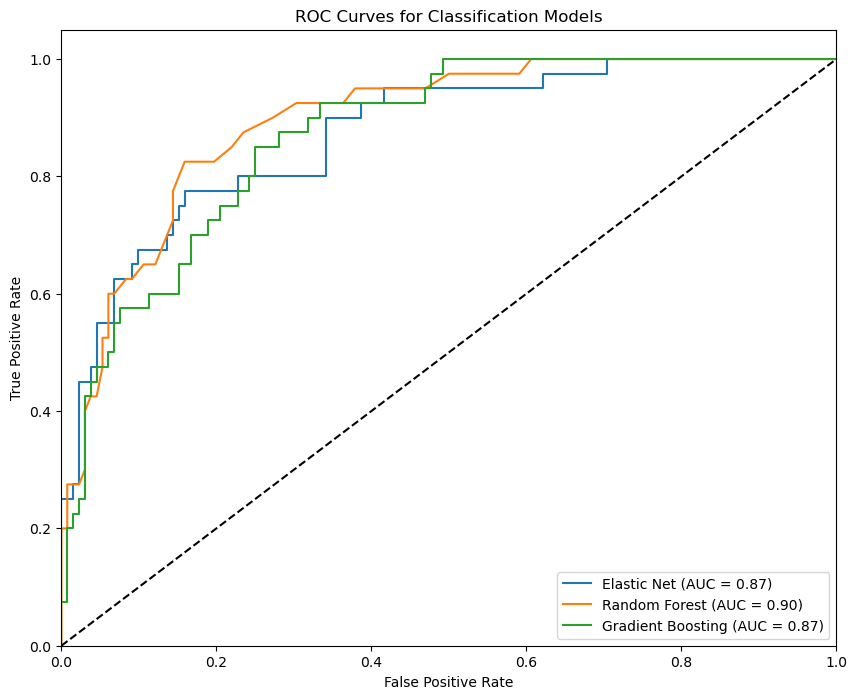


Training models on differentially expressed genes:


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


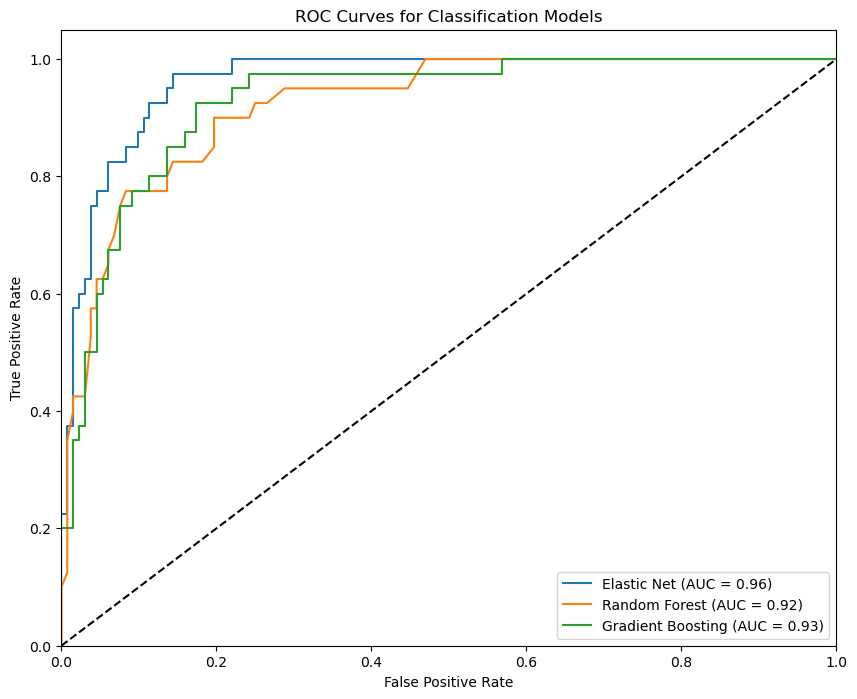


Results for top 2% expressed genes:

Elastic Net:
AUC: 0.874

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       132
           1       0.74      0.62      0.68        40

    accuracy                           0.86       172
   macro avg       0.81      0.78      0.79       172
weighted avg       0.86      0.86      0.86       172


Confusion Matrix:
[[123   9]
 [ 15  25]]

Random Forest:
AUC: 0.895

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       132
           1       0.75      0.53      0.62        40

    accuracy                           0.85       172
   macro avg       0.81      0.74      0.76       172
weighted avg       0.84      0.85      0.84       172


Confusion Matrix:
[[125   7]
 [ 19  21]]

Gradient Boosting:
AUC: 0.872

Classification Report:
              precision    recall  f1-score   support

           0   

In [38]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.linear_model import LogisticRegression, ElasticNet
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
# from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
# import matplotlib.pyplot as plt
# import seaborn as sns

# baby = None

# # Data Preprocessing Function
# def preprocess_data(X, y, task='classification'):
#     # Encode categorical labels
#     if task == 'classification':
#         le = LabelEncoder()
#         y = le.fit_transform(y)
    
#     # Split data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     # Scale features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     return X_train_scaled, X_test_scaled, y_train, y_test

# # Model Training & Evaluation Function for Classification
# def train_evaluate_classification_models(X_train, X_test, y_train, y_test):
#     global baby
#     models = {
#         'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
#                                         l1_ratio=0.5, max_iter=1000),
#         'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
#         'Gradient Boosting': GradientBoostingClassifier(random_state=42)
#     }
    
#     results = {}
#     plt.figure(figsize=(10, 8))
    
#     for name, model in models.items():
#         # Train model
#         model.fit(X_train, y_train)
        
#         # Get predictions
#         y_pred_proba = model.predict_proba(X_test)[:, 1]
#         y_pred = model.predict(X_test)
        
#         # Calculate metrics
#         fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
#         roc_auc = auc(fpr, tpr)
        
#         # Plot ROC curve
#         plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        
#         # Store results
#         results[name] = {
#             'AUC': roc_auc,
#             'Confusion Matrix': confusion_matrix(y_test, y_pred),
#             'Classification Report': classification_report(y_test, y_pred)
#         }

#         if name == 'Elastic Net':
#             baby = model
    
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curves for Classification Models')
#     plt.legend(loc="lower right")
#     plt.show()
    
#     return results

# # Main execution
# def main():
#     # For top 2% expressed genes
#     print("Training models on top 2% expressed genes:")
    
#     # Classification
#     X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
#         filtered_df_tp2_percent, softLabel_metadata['HRD_status_base'], task='classification'
#     )
    
#     results_top = train_evaluate_classification_models(
#         X_train_top, X_test_top, y_train_top, y_test_top
#     )
    
#     # For differentially expressed genes
#     print("\nTraining models on differentially expressed genes:")
    
#     X_train_de, X_test_de, y_train_de, y_test_de = preprocess_data(
#         common_de_genes, softLabel_metadata['HRD_status_base'], task='classification'
#     )
    
#     results_de = train_evaluate_classification_models(
#         X_train_de, X_test_de, y_train_de, y_test_de
#     )
    
#     # Print results
#     print("\nResults for top 2% expressed genes:")
#     for model_name, metrics in results_top.items():
#         print(f"\n{model_name}:")
#         print(f"AUC: {metrics['AUC']:.3f}")
#         print("\nClassification Report:")
#         print(metrics['Classification Report'])
#         print("\nConfusion Matrix:")
#         print(metrics['Confusion Matrix'])
    
#     print("\nResults for differentially expressed genes:")
#     for model_name, metrics in results_de.items():
#         print(f"\n{model_name}:")
#         print(f"AUC: {metrics['AUC']:.3f}")
#         print("\nClassification Report:")
#         print(metrics['Classification Report'])
#         print("\nConfusion Matrix:")
#         print(metrics['Confusion Matrix'])

# # For regression task on Confidence values
# def train_evaluate_regression_models(X_train, X_test, y_train, y_test):
#     models = {
#         'Elastic Net': ElasticNet(random_state=42),
#         'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
#         'Gradient Boosting': GradientBoostingRegressor(random_state=42)
#     }
    
#     results = {}
    
#     for name, model in models.items():
#         # Train model
#         model.fit(X_train, y_train)
        
#         # Get predictions
#         y_pred = model.predict(X_test)
        
#         # Calculate metrics
#         mse = mean_squared_error(y_test, y_pred)
#         r2 = r2_score(y_test, y_pred)
        
#         # Store results
#         results[name] = {
#             'MSE': mse,
#             'R2': r2,
#             'Model': model
#         }
        
#         # Plot actual vs predicted
#         plt.figure(figsize=(8, 6))
#         plt.scatter(y_test, y_pred, alpha=0.5)
#         plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
#         plt.xlabel('Actual Confidence')
#         plt.ylabel('Predicted Confidence')
#         plt.title(f'{name} - Actual vs Predicted')
#         plt.show()
    
#     return results

# # # Run regression models
# # def run_regression():
# #     print("\nTraining regression models for Confidence prediction:")
    
# #     # For top 2% expressed genes
# #     X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
# #         rnaseq_df_top_genes, brca_df_common['Confidence'], task='regression'
# #     )
    
# #     results_top_reg = train_evaluate_regression_models(
# #         X_train_top, X_test_top, y_train_top, y_test_top
# #     )
    
# #     print("\nRegression Results for top 2% expressed genes:")
# #     for model_name, metrics in results_top_reg.items():
# #         print(f"\n{model_name}:")
# #         print(f"MSE: {metrics['MSE']:.6f}")
# #         print(f"R2: {metrics['R2']:.3f}")

# googoog = main()
# #run_regression()

/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


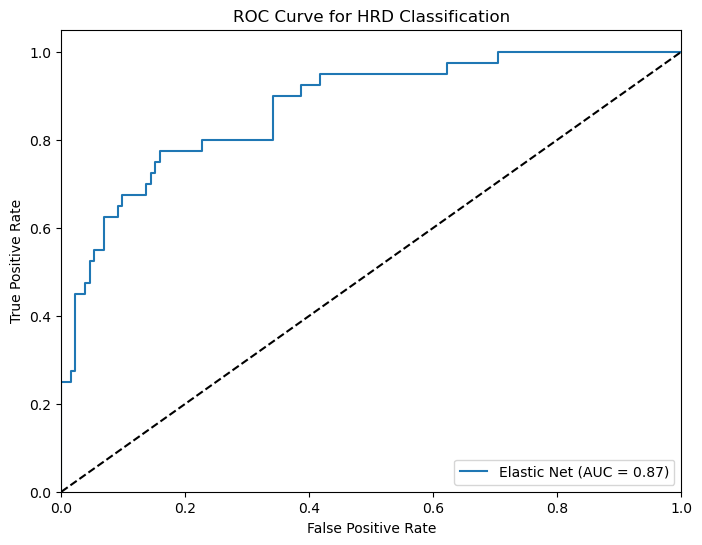


Elastic Net Classification Results:
AUC: 0.873

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       132
           1       0.74      0.62      0.68        40

    accuracy                           0.86       172
   macro avg       0.81      0.78      0.79       172
weighted avg       0.86      0.86      0.86       172


Confusion Matrix:
[[123   9]
 [ 15  25]]


In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt

def preprocess_data(X, y):
    """
    Preprocess data for classification with label encoding and scaling.
    
    Parameters:
    X: Feature matrix (RNA-seq data)
    y: Target vector (HRD status)
    """
    # Encode categorical labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def train_evaluate_elastic_net(X_train, X_test, y_train, y_test):
    """
    Train and evaluate Elastic Net model for HRD classification.
    """
    # Initialize and train model
    model = LogisticRegression(penalty='elasticnet', solver='saga', 
                             l1_ratio=0.5, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Elastic Net (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for HRD Classification')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'AUC': roc_auc,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred),
        'Model': model
    }

def main(filtered_df_tp2_percent, hrd_status):
    """
    Main function to run HRD classification using Elastic Net.
    
    Parameters:
    filtered_df_tp2_percent: DataFrame with top 2% expressed genes
    hrd_status: Series with HRD status labels
    """
    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data(
        filtered_df_tp2_percent, hrd_status
    )
    
    # Train and evaluate model
    results = train_evaluate_elastic_net(X_train, X_test, y_train, y_test)
    
    # Print results
    print("\nElastic Net Classification Results:")
    print(f"AUC: {results['AUC']:.3f}")
    print("\nClassification Report:")
    print(results['Classification Report'])
    print("\nConfusion Matrix:")
    print(results['Confusion Matrix'])
    
    return results

if __name__ == "__main__":
    # The main function should be called with your preprocessed data:
    results = main(filtered_df_tp2_percent, softLabel_metadata['HRD_status_base'])

/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


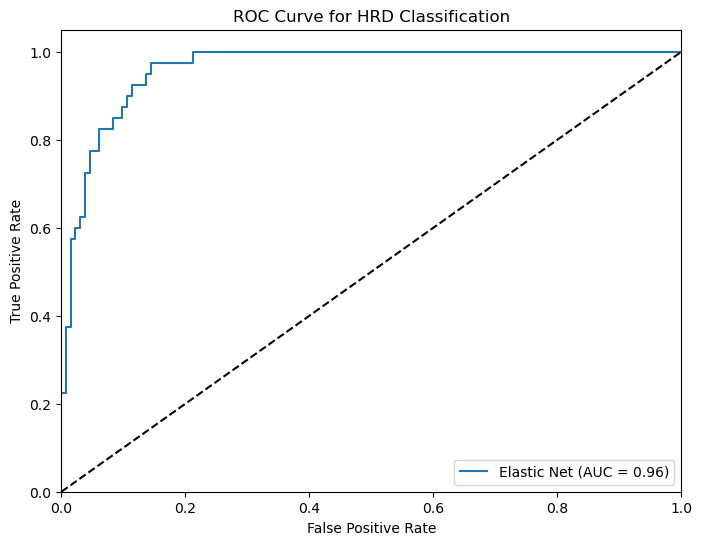


Elastic Net Classification Results:
AUC: 0.963

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       132
           1       0.77      0.82      0.80        40

    accuracy                           0.90       172
   macro avg       0.86      0.87      0.87       172
weighted avg       0.90      0.90      0.90       172


Confusion Matrix:
[[122  10]
 [  7  33]]


In [42]:
results =  main(common_de_genes, softLabel_metadata['HRD_status_base'])

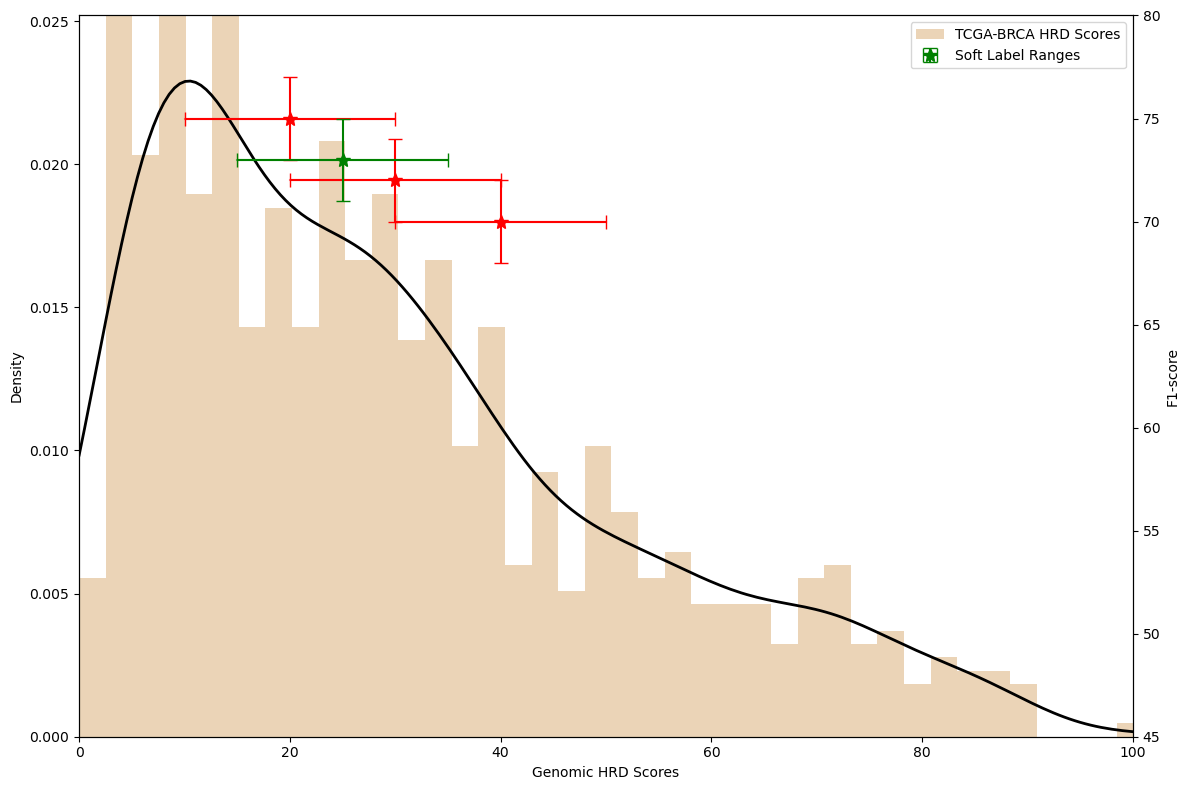

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import f1_score
import seaborn as sns

# # Set the style for the plot
# plt.style.use('seaborn')
# sns.set_palette("husl")

# Create figure with secondary y-axis
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

# Generate sample HRD scores (replace with your actual data)
hrd_scores = softLabel_metadata['HRD-sum']

# Calculate KDE
kde = stats.gaussian_kde(hrd_scores)
x_range = np.linspace(0, 100, 200)
density = kde(x_range)

# Create histogram
hist_counts, hist_bins, _ = ax1.hist(hrd_scores, bins=40, density=True, 
                                   alpha=0.6, color='burlywood', 
                                   label='TCGA-BRCA HRD Scores')
ax1.plot(x_range, density, 'k-', lw=2)

# Set up the soft label ranges and F1 scores (example data - replace with your actual values)
ranges = [(10, 30), (20, 40), (30, 50)]  # Example ranges
f1_scores = [75, 72, 70]  # Example F1 scores
ci_errors = [2, 2, 2]  # Example confidence intervals

# Plot error bars for each range
for (start, end), f1, err in zip(ranges, f1_scores, ci_errors):
    mid_point = (start + end) / 2
    ax2.errorbar(mid_point, f1, xerr=(end-start)/2, yerr=err,
                fmt='r*', markersize=10, capsize=5)
    ax2.plot([start, end], [f1, f1], 'r-', alpha=0.5)

# Add DeepHRD range (example - adjust as needed)
deep_hrd_range = (15, 35)
deep_hrd_f1 = 73
deep_hrd_err = 2
ax2.errorbar(np.mean(deep_hrd_range), deep_hrd_f1, 
            xerr=(deep_hrd_range[1]-deep_hrd_range[0])/2,
            yerr=deep_hrd_err, fmt='g*', markersize=10, capsize=5,
            label='DeepHRD Soft Label Range')
ax2.plot(deep_hrd_range, [deep_hrd_f1, deep_hrd_f1], 'g-', alpha=0.5)

# Customize the plot
ax1.set_xlabel('Genomic HRD Scores')
ax1.set_ylabel('Density')
ax2.set_ylabel('F1-score')

# Set axis limits
ax1.set_xlim(0, 100)
ax1.set_ylim(0, max(density) * 1.1)
ax2.set_ylim(45, 80)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + ['Soft Label Ranges', 'DeepHRD Soft Label Range'],
          loc='upper right')

# Adjust layout and display
plt.tight_layout()
plt.show()